# **SECTION 1: OBTAINING AND PREPROCESSING DATA**

The data I will use comes amazon review data. In particular, the data I use comes from 1613536 reviews on CD's, Vinyl's, and digital music.

I will only be using a subset of these reviews, and only the 'reviewText' and 'overall' attributes will be needed.

Each review object contains:
* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* vote - helpful votes of the review
* style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
* reviewText - text of the review
* overall - rating of the product (1-5)
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)
* image - images that users post after they have received the product



---




### **Section (1.1): Getting datafiles onto colab**

In [ ]:
import os
import requests

# Specify the URLs of the files you want to download
file_urls = {
    'file1.gz': 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz',
    'file2.gz': 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
}

# Specify the output directory in Colab
output_directory = "/content/"

# Download files to the output directory
for filename, url in file_urls.items():
    output_path = os.path.join(output_directory, filename)
    response = requests.get(url, verify=False)
    with open(output_path, 'wb') as f:
        f.write(response.content)


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jmcauley.ucsd.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jmcauley.ucsd.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
# Parses through the review data files and stores each review in all_reviews

# NOTE: Takes about a minute to run

from collections import Counter
import gzip
import json
import os
import random

all_reviews = []

# Path to the directory containing your data files
data_directory = "/content/"

# Iterate over each file in the directory
for filename in os.listdir(data_directory):
    if filename.endswith(".gz"):
        # Path to the compressed JSON file
        json_gz_file = os.path.join(data_directory, filename)

        # Open the compressed JSON file and extract its contents
        with gzip.open(json_gz_file, 'rt') as f:
            # Read each line and parse it as JSON
            for line in f:
                review = json.loads(line.strip())
                all_reviews.append(review)

print("succesfully loaded:", len(all_reviews), "reviews.")

succesfully loaded: 1613536 reviews.




---



### **Section (1.2): Preprocessing**
At this point we have a list "all_reviews" containing 1613536 review objects. In this section we will create a subset of these reviews to work with. To do this corectly we must randomly sample while also ensuring equal distribution across the 'overall' attributes.

In [ ]:
# Lets take a look at the current distribution of 'overall' in our reviews

# Count the frequencies of each 'overall' rating in the entire dataset
overall_ratings_counts = Counter(review['overall'] for review in all_reviews)

print("all_reviews 'overall' distribution:", overall_ratings_counts)
print("total reviews in all_reviews:", len(all_reviews))


all_reviews 'overall' distribution: Counter({5.0: 1104597, 4.0: 297874, 3.0: 117199, 2.0: 48179, 1.0: 45687})
total reviews in all_reviews: 1613536


Here we convert the 1-5 amazon rating system into three classes (-1,0,1)

In [ ]:
# Iterate over the reviews in all_reviews and edit the 'overall' value
for review in all_reviews:
    rating = review['overall']
    if rating <= 2:
        review['overall'] = -1
    elif rating <= 4:
        review['overall'] = 0
    else:
        review['overall'] = 1

# Count the frequencies of each 'overall' rating in the entire dataset
overall_ratings_counts = Counter(review['overall'] for review in all_reviews)

print("all_reviews 'overall' distribution:", overall_ratings_counts)
print("total reviews in all_reviews:", len(all_reviews))

all_reviews 'overall' distribution: Counter({1: 1104597, 0: 415073, -1: 93866})
total reviews in all_reviews: 1613536


As we can see the distribution is heavily skewed towards more good reviews and less bad ones. Lets make a smaller subset of all_reviews to work with, and let's ensure equal distribution of 'overall' scores across the new subset.

In [ ]:
# Set desired sample size for each class
total_samples = 10000
sample_size_per_class = {rating: total_samples // len(overall_ratings_counts) for rating in overall_ratings_counts}

# Initialize a dictionary to store sampled reviews
sampled_reviews = {rating: [] for rating in overall_ratings_counts}

# Iterate over the reviews and perform stratified sampling
for review in all_reviews:
    rating = review['overall']
    if len(sampled_reviews[rating]) < sample_size_per_class[rating]:
        sampled_reviews[rating].append(review)
    else:
        # Randomly replace existing samples with new samples
        idx = random.randint(0, len(sampled_reviews[rating]) - 1)
        if random.random() < sample_size_per_class[rating] / len(sampled_reviews[rating]):
            sampled_reviews[rating][idx] = review

# Flatten the sampled reviews into a single list
final_stratified_sample = [review for sublist in sampled_reviews.values() for review in sublist]

# Count the frequencies of each 'overall' rating in the stratified sampled dataset
strat_samples = Counter(review['overall'] for review in final_stratified_sample)
print("new distribution:", strat_samples)

print("total reviews in subset:", len(final_stratified_sample))


new distribution: Counter({1: 3333, 0: 3333, -1: 3333})
total reviews in subset: 9999


In [ ]:
print(final_stratified_sample[0])
print(final_stratified_sample[3333])
print(final_stratified_sample[6666])

{'overall': 1, 'verified': True, 'reviewTime': '04 6, 2018', 'reviewerID': 'A1LKCGKFIED2F2', 'asin': 'B00OV9IXMI', 'style': {'Format:': ' MP3 Music'}, 'reviewerName': 'Chuck Gough', 'reviewText': 'Great song', 'summary': 'Awesome', 'unixReviewTime': 1522972800}
{'overall': 0, 'verified': True, 'reviewTime': '02 1, 2016', 'reviewerID': 'AMTIG63PJHLIG', 'asin': 'B00137TEE2', 'style': {'Format:': ' MP3 Music'}, 'reviewerName': 'Amazon Customer', 'reviewText': "Haven't heard since I was little", 'summary': 'Three Stars', 'unixReviewTime': 1454284800}
{'overall': -1, 'verified': True, 'reviewTime': '01 9, 2015', 'reviewerID': 'AZAW12EWF3O6G', 'asin': 'B006L5O9GY', 'reviewerName': 'RVMY', 'reviewText': 'Not worth the price: this digital download was free!', 'summary': '...', 'unixReviewTime': 1420761600}


Now that we have the subset, lets remove all but 'overall' and 'reviewText' for each review.

In [ ]:
# Create a new list to store dictionaries with 'reviewText' key
filtered_final_stratified_sample = []

# Iterate through each dictionary in final_stratified_sample
for review in final_stratified_sample:
    # Check if 'reviewText' key exists in the review dictionary
    if 'reviewText' in review:
        # Create a new dictionary containing only the 'reviewText' and 'overall' attributes
        new_review = {'reviewText': review['reviewText'], 'overall': review['overall']}
        # Append the new dictionary to the filtered list
        filtered_final_stratified_sample.append(new_review)

In [ ]:
print("length of original:", len(final_stratified_sample))
print("length of filtered:", len(filtered_final_stratified_sample))
print("number of reviews without reviewText removed:",len(final_stratified_sample)-len(filtered_final_stratified_sample))
print()
print(filtered_final_stratified_sample[0])
print(filtered_final_stratified_sample[3333])
print(filtered_final_stratified_sample[6666])

length of original: 9999
length of filtered: 9990
number of reviews without reviewText removed: 9

{'reviewText': 'Great song', 'overall': 1}
{'reviewText': 'I like hearing how the lord speaks to artist.', 'overall': 0}
{'reviewText': "It wasn't the song I was thinking about!", 'overall': -1}


Now lets process the reviewText even further to prepare it for feature extraction, removing punctuation and leaving behind only the words seperated by spaces.

In [ ]:
import nltk
import string

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text = text.lower()

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Remove special characters and digits
    text = ''.join(character for character in text if character.isalpha() or character.isspace())

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Loop through each dictionary in parsed_text
for review in filtered_final_stratified_sample:
    # Access the 'reviewText' value from the dictionary
    review_text = review['reviewText']

    # Clean the text using the clean_text function
    cleaned_text = clean_text(review_text)

    review['reviewText'] = cleaned_text

In [ ]:
print(filtered_final_stratified_sample[0])
print(filtered_final_stratified_sample[3333])
print(filtered_final_stratified_sample[6666])

{'reviewText': 'great song', 'overall': 1}
{'reviewText': 'like hearing lord speaks artist', 'overall': 0}
{'reviewText': 'wasnt song thinking', 'overall': -1}


---

# **SECTION 2: FEATURE EXTRACTION**

Here I tokenize the data

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Ensure NLTK tokenizer is downloaded (only need to run this once)
nltk.download('punkt')

# Tokenize review texts for all the reviews
for review in filtered_final_stratified_sample:
    review_text = review['reviewText']
    tokens = word_tokenize(review_text)
    review['reviewText'] = tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(filtered_final_stratified_sample[0])
print(filtered_final_stratified_sample[3333])
print(filtered_final_stratified_sample[6666])

{'reviewText': ['great', 'song'], 'overall': 1}
{'reviewText': ['like', 'hearing', 'lord', 'speaks', 'artist'], 'overall': 0}
{'reviewText': ['wasnt', 'song', 'thinking'], 'overall': -1}


# 1.1 Bag of Words
A simple and basic approach for text representation in natural language processing. It involves representing text data as a collection of words, disregarding grammar and word order, and focusing only on the frequency of occurrence of words in a document.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract tokenized review texts
tokenized_texts = [review['reviewText'] for review in filtered_final_stratified_sample]

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the tokenized texts and transform them into BoW features
bow_features = vectorizer.fit_transform([' '.join(tokens) for tokens in tokenized_texts])

# Convert the BoW features to an array
bow_features_array = bow_features.toarray()

# Print the shape of the BoW features array
print("Shape of BoW features array:", bow_features_array.shape)


Shape of BoW features array: (9990, 21639)


In [ ]:
print(filtered_final_stratified_sample[0])
print(filtered_final_stratified_sample[3333])
print(filtered_final_stratified_sample[6666])

{'reviewText': ['great', 'song'], 'overall': 1}
{'reviewText': ['like', 'hearing', 'lord', 'speaks', 'artist'], 'overall': 0}
{'reviewText': ['wasnt', 'song', 'thinking'], 'overall': -1}


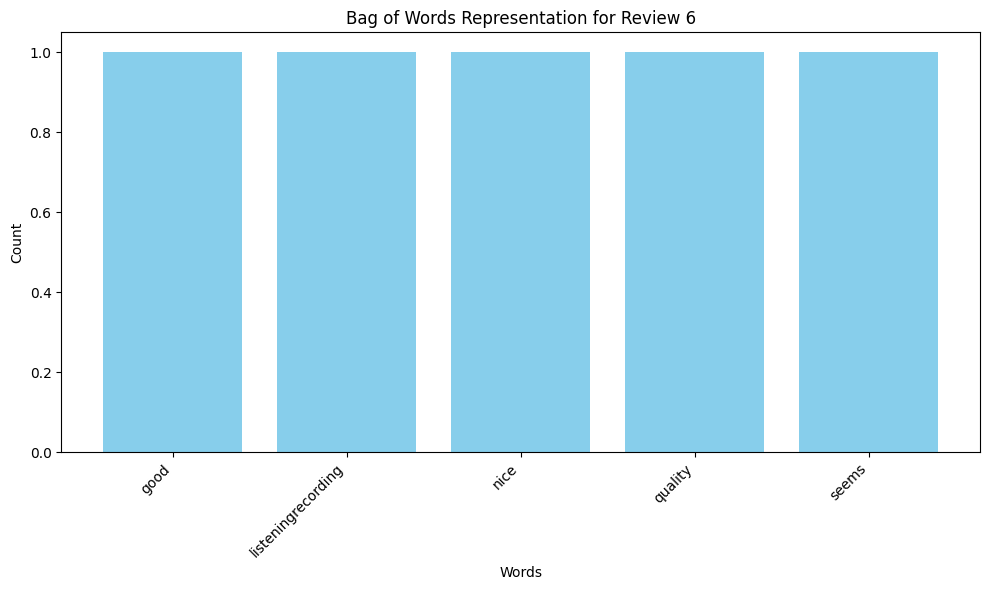

In [ ]:
# This here finds a good review to plot

import matplotlib.pyplot as plt

i = 0
p = len(filtered_final_stratified_sample[i]['reviewText'])
while p > 20 or p < 5:
  i = i + 1
  p = len(filtered_final_stratified_sample[i]['reviewText'])

# Select a review index to visualize its BoW representation
review_index = i

# Get the tokenized text and BoW features for the selected review
tokens = filtered_final_stratified_sample[review_index]['reviewText']
bow_features_row = bow_features_array[review_index]

# Create a dictionary mapping each word to its count in the review
word_count_dict = {word: count for word, count in zip(vectorizer.get_feature_names_out(), bow_features_row)}

# Sort the word count dictionary by count in descending order
sorted_word_count = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their counts for visualization
top_n = len(filtered_final_stratified_sample[review_index]['reviewText']) # Change this value to visualize more or fewer words
top_words = [pair[0] for pair in sorted_word_count[:top_n]]
top_counts = [pair[1] for pair in sorted_word_count[:top_n]]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Bag of Words Representation for Review {}'.format(review_index))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# 1.2 Term Frequency-Inverse Document Frequency

TF-IDF is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents. It is calculated by multiplying the frequency of a term in a document by the logarithm of the inverse document frequency.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract tokenized review texts
tokenized_texts = [' '.join(review['reviewText']) for review in filtered_final_stratified_sample]

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the tokenized texts and transform them into TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(tokenized_texts)

# Convert the TF-IDF features to an array
tfidf_features_array = tfidf_features.toarray()

# Print the shape of the TF-IDF features array
print("Shape of TF-IDF features array:", tfidf_features_array.shape)


Shape of TF-IDF features array: (9990, 21639)


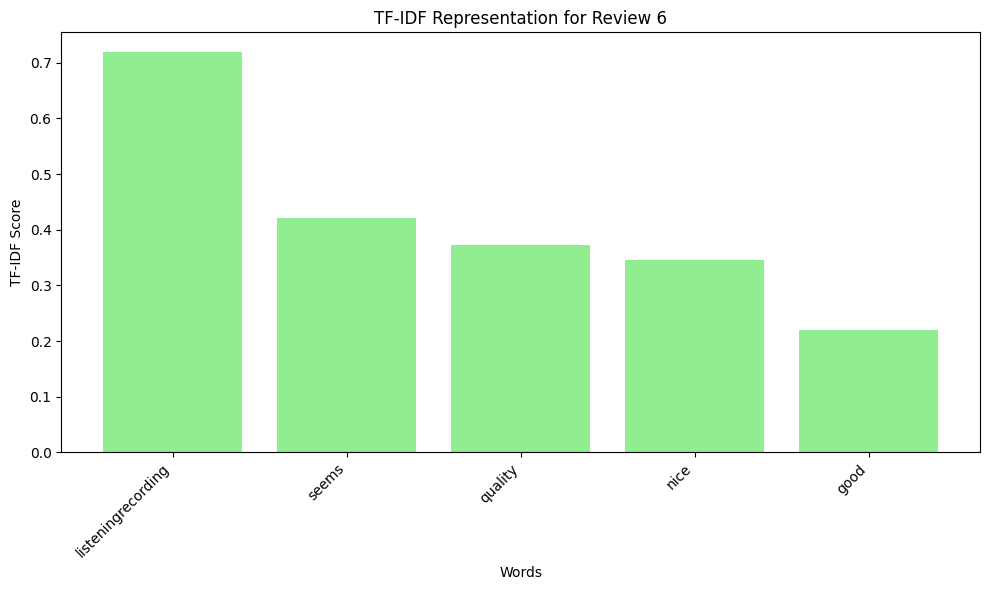

In [ ]:
import matplotlib.pyplot as plt

i = 0
p = len(filtered_final_stratified_sample[i]['reviewText'])
while p > 20 or p < 5:
  i = i + 1
  p = len(filtered_final_stratified_sample[i]['reviewText'])

# Select a review index to visualize its TF-IDF representation
review_index = i

# Get the tokenized text and TF-IDF features for the selected review
tokens = filtered_final_stratified_sample[review_index]['reviewText']
tfidf_features_row = tfidf_features_array[review_index]

# Create a dictionary mapping each word to its TF-IDF score in the review
word_tfidf_dict = {word: tfidf_score for word, tfidf_score in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_features_row)}

# Sort the word-TF-IDF dictionary by TF-IDF score in descending order
sorted_word_tfidf = sorted(word_tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top N words and their TF-IDF scores for visualization
top_n = len(filtered_final_stratified_sample[i]['reviewText'])  # Change this value to visualize more or fewer words
top_words = [pair[0] for pair in sorted_word_tfidf[:top_n]]
top_tfidf_scores = [pair[1] for pair in sorted_word_tfidf[:top_n]]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words, top_tfidf_scores, color='lightgreen')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('TF-IDF Representation for Review {}'.format(review_index))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2.3 Word Embeddings

Word embeddings are dense vector representations of words in a continuous vector space where each word is mapped to a high-dimensional vector. These embeddings capture semantic relationships between the words.

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

token_text = []

for i in range(len(filtered_final_stratified_sample)):
  token = filtered_final_stratified_sample[i]['reviewText']
  token_text.append(token)


# Define Word2Vec model parameters
vector_size = 100  # Dimensionality of the word vectors
window_size = 5  # Context window size
min_word_count = 1  # Minimum word frequency
epochs = 10  # Number of training epochs

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=token_text,
    vector_size=vector_size,
    window=window_size,
    min_count=min_word_count,
    epochs=epochs
)

# Get word embeddings
word_embeddings = word2vec_model.wv


This is an interesting application of the word embeddings that calculates similarity

In [ ]:
# Example: Find similar words to the word 'good'
similar_words = word_embeddings.most_similar('great', topn=10)
print("Words similar to 'great':", similar_words)

Words similar to 'great': [('barlow', 0.9546953439712524), ('awesome', 0.9451895952224731), ('nice', 0.9374719262123108), ('catchy', 0.9366359710693359), ('good', 0.9355006814002991), ('background', 0.934508740901947), ('terrible', 0.9315623641014099), ('ruins', 0.9301469326019287), ('aight', 0.9301304221153259), ('kind', 0.9299644827842712)]




---



# **SECTION 3: MODEL SELECTION AND TRAINING**

So I have to admit I spent a very long time attempting to concatenate all three of the features (TF-IDF, BoW, and word_embeddings) but I realized that word_embeddings are more fit for neural networks than SVM so instead I just use BoW and TF-IDF.

In [ ]:
# Here i'm just extracting all the rating reviews into an array

overall_rating = []

for i in range(len(filtered_final_stratified_sample)):
  rating = filtered_final_stratified_sample[i]['overall']
  overall_rating.append(rating)

# 3.1 Baseline model

In [ ]:
# Here I'm establishing a baseline score that you'd expect if the model were
# just choosing randomly. It's as expected for the 3 classes (-1,0,1) at 33%

import numpy as np

# Assuming equal distribution of classes (-1, 0, 1)
num_samples = len(filtered_final_stratified_sample)
class_distribution = { -1: 1/3, 0: 1/3, 1: 1/3 }

# Generate random labels based on class distribution
random_labels = np.random.choice(list(class_distribution.keys()), size=num_samples, p=list(class_distribution.values()))

# Evaluate the performance of the random classifier (e.g., accuracy)
# Assuming y_true contains the true sentiment labels from the dataset
accuracy = (random_labels == overall_rating).mean()
print("Accuracy of random classifier:", accuracy)


Accuracy of random classifier: 0.33943943943943944


In [ ]:
# just double checking the shapes and types before going further

print(type(bow_features))
print(bow_features.shape)
print(type(tfidf_features))
print(tfidf_features.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(9990, 21639)
<class 'scipy.sparse._csr.csr_matrix'>
(9990, 21639)


# 3.2 prepping feature data

In [ ]:
# Here I'm combining the bag of words and tf-idf features

from scipy.sparse import hstack

# Concatenate TF-IDF and BoW matrices horizontally
X_combined = hstack([tfidf_features, bow_features])

# Now X_combined is a combined sparse matrix containing both TF-IDF and BoW features
print("Combined shape:", X_combined.shape)

Combined shape: (9990, 43278)


In [ ]:
# visualization

print((X_combined[0]))

  (0, 17631)	0.5997111732282331
  (0, 7971)	0.8002165386351472
  (0, 29610)	1.0
  (0, 39270)	1.0


In [ ]:
# double checking that lengths match

print(X_combined.shape)
print(len(overall_rating))

(9990, 43278)
9990


In [ ]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, overall_rating, test_size=0.2, random_state=42)

In [ ]:
# Choose the size of the subset
subset_size = int(0.1 * X_train.shape[0])

# Create a smaller subset of the training and testing data
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

X_test_subset = X_test[:subset_size]
y_test_subset = y_test[:subset_size]

print(X_train.shape[0])
print(X_train_subset.shape[0])

7992
799


#3.3 BoW / TF-IDF MODEL TRAINING

# With rbf kernel

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],          # List of C values to try
    'gamma': [0.01, 0.1, 1],    # List of gamma values to try
}

# Initialize SVM classifier with RBF kernel
rbf_svm_classifier = SVC(kernel='rbf')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rbf_svm_classifier, param_grid=param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train_subset, y_train_subset)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best cross-validation score:", best_score)

Best hyperparameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.5968789308176101


In [ ]:

print(best_params.keys())
print(best_params)

dict_keys(['C', 'gamma'])
{'C': 10, 'gamma': 0.01}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize SVM classifier
rbf_svm_classifier = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])

# Train the SVM model
rbf_svm_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rbf_svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.77      0.79       660
           0       0.57      0.61      0.59       663
           1       0.68      0.68      0.68       675

    accuracy                           0.69      1998
   macro avg       0.69      0.69      0.69      1998
weighted avg       0.69      0.69      0.69      1998



# With linear Kernel

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],          # List of C values to try

}

# Initialize SVM classifier
linear_svm_classifier = SVC(kernel='linear')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=linear_svm_classifier, param_grid=param_grid, cv=5)

# Perform grid search
grid_search.fit(X_train_subset, y_train_subset)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best cross-validation score
best_score = grid_search.best_score_
print("Best cross-validation score:", best_score)



Best hyperparameters: {'C': 0.1}
Best cross-validation score: 0.56437106918239


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize SVM classifier
linear_svm_classifier = SVC(kernel='linear', C=best_params['C'])

# Train the SVM model
linear_svm_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = linear_svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.83      0.72      0.77       660
           0       0.55      0.62      0.58       663
           1       0.67      0.68      0.68       675

    accuracy                           0.67      1998
   macro avg       0.69      0.67      0.68      1998
weighted avg       0.69      0.67      0.68      1998





---



# Conclusion

So as we can see the rbf kernel svm with C of 10 and gamma of 0.01 scored the highest in the end.

In [ ]:
# Initialize SVM classifier
rbf_svm_classifier = SVC(kernel='rbf', C=10, gamma=0.01)

# Train the SVM model
rbf_svm_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rbf_svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.82      0.77      0.79       660
           0       0.57      0.61      0.59       663
           1       0.68      0.68      0.68       675

    accuracy                           0.69      1998
   macro avg       0.69      0.69      0.69      1998
weighted avg       0.69      0.69      0.69      1998



Definitely not perfect, but based on the benchmark of 30% it's pretty decent. Unfortunately the dimenstionality of the sparse matrix format of the features makes it difficult to visualize which is why there are no graph/plots displaying the decision boundaries.